
#Cohen Experiment
On this notebook is the development of the model using Only Cohen dataset in which we generate the score column of the dataset that represent the prediction of each of the images on the dataset to be able to analize it with Aequitas tool

Originally this file was a Colab Notebook

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import seaborn as sn
import cv2
from time import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import datasets,layers,models,Input,Model
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad, SGD, Adadelta
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import os
import sys
import fnmatch
import random
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, AveragePooling2D, Cropping2D
from tensorflow.keras.layers import Dropout, Activation, Flatten, Concatenate, Dense, Reshape, Add, PReLU, LeakyReLU, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization as BN
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad, SGD, Adadelta
from tensorflow.keras.applications import vgg16, vgg19, InceptionV3, Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils.data_utils import Sequence, is_generator_or_sequence


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.calibration import calibration_curve
from mlxtend.plotting import plot_confusion_matrix

from skimage import io,color
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Bias Covid/covid-chestxray-dataset-master/metadata.csv")
data.head()

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [ ]:
data['modality'].unique()

array(['X-ray', 'CT'], dtype=object)

In [ ]:
data = data[data['modality'] == 'X-ray']

#Filter patient and generate datasets

In [ ]:
data['patientid'] = [int(x.replace('a','').replace('b','').replace('c','').replace('d','')) for x in data['patientid'].values]

In [ ]:
train_p, test_p = train_test_split(data['patientid'].unique(), test_size=0.2)

In [ ]:
data_train = data[data['patientid'].isin(train_p)]
data_test = data[data['patientid'].isin(test_p)]

In [ ]:
data_train.shape

(704, 30)

In [ ]:
data_test.shape

(162, 30)

In [ ]:
data_train.to_csv('/content/drive/MyDrive/Bias Covid/data_train.csv')
data_test.to_csv('/content/drive/MyDrive/Bias Covid/data_test.csv')

# Turn df in NPY

In [4]:
data_train = pd.read_csv('/content/drive/MyDrive/Bias Covid/data_train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Bias Covid/data_test.csv')

In [5]:
data_train.head()

,Unnamed: 0,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [6]:
len(data_train.patientid.unique())

348

In [7]:
len(data_test.patientid.unique())

87

In [8]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [9]:
def convert_csv(path,DF,src_column,S,y_column):
    src_dir = path
    images = []
    y = []
    print('reading images...')
    for i,j in tqdm(zip(DF[src_column],DF[y_column])):
        src_file = os.path.join(src_dir, i)
        if os.path.isfile(src_file):
          img = cv2.imread(src_file,-1)
          if len(img.shape) == 3:
            img = rgb2gray(img)
          resized = cv2.resize(img, (S, S))
          images.append(resized)
          if j == 'Pneumonia/Viral/COVID-19':
            y.append([1,0])
          else:
            y.append([0,1])

    NPY = np.array(images)
    Y = np.array(y)
    return NPY, Y

In [10]:
train_npy, y_train = convert_csv('/content/drive/MyDrive/Bias Covid/covid-chestxray-dataset-master/images',data_train,'filename',224,'finding')
train_npy.shape

reading images...


704it [09:25,  1.25it/s]


(704, 224, 224)

In [11]:
test_npy, y_test = convert_csv('/content/drive/MyDrive/Bias Covid/covid-chestxray-dataset-master/images',data_test,'filename',224,'finding')
test_npy.shape

reading images...


162it [01:54,  1.41it/s]


(162, 224, 224)

In [12]:
np.save('/content/drive/MyDrive/Bias Covid/train.npy',train_npy)
np.save('/content/drive/MyDrive/Bias Covid/test.npy',test_npy)

#Models

In [ ]:
def get_model_VGG19_gray():
      model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

      # Block1_conv1 weights are of the format [3, 3, 3, 64] -> this is for RGB images
      # For grayscale, format should be [3, 3, 1, 64]. Weighted average of the features has to be calculated across channels.
      # RGB weights: Red 0.2989, Green 0.5870, Blue 0.1140

      # getting weights of block1 conv1.
      block1_conv1 = model.get_layer('block1_conv1').get_weights()
      weights, biases = block1_conv1

      # :weights shape = [3, 3, 3, 64] - (0, 1, 2, 3)
      # convert :weights shape to = [64, 3, 3, 3] - (3, 2, 0, 1)
      weights = np.transpose(weights, (3, 2, 0, 1))


      kernel_out_channels, kernel_in_channels, kernel_rows, kernel_columns = weights.shape

      # Dimensions : [kernel_out_channels, 1 (since grayscale), kernel_rows, kernel_columns]
      grayscale_weights = np.zeros((kernel_out_channels, 1, kernel_rows, kernel_columns))

      # iterate out_channels number of times
      for i in range(kernel_out_channels):

        # get kernel for every out_channel
        get_kernel = weights[i, :, :, :]

        temp_kernel = np.zeros((3, 3))

        # :get_kernel shape = [3, 3, 3]
        # axis, dims = (0, in_channel), (1, row), (2, col)

        # calculate weighted average across channel axis
        in_channels, in_rows, in_columns = get_kernel.shape

        for in_row in range(in_rows):
          for in_col in range(in_columns):
            feature_red = get_kernel[0, in_row, in_col]
            feature_green = get_kernel[1, in_row, in_col]
            feature_blue = get_kernel[2, in_row, in_col]

            # weighted average for RGB filter
            total = (feature_red * 0.2989) + (feature_green * 0.5870) + (feature_blue * 0.1140)

            temp_kernel[in_row, in_col] = total


        # :temp_kernel is a 3x3 matrix [rows x columns]
        # add an axis at the end to specify in_channel as 1

        # Second: Add axis at the start of :temp_kernel to make its shape: [1, 3, 3] which is [in_channel, rows, columns]
        temp_kernel = np.expand_dims(temp_kernel, axis=0)

        # Now, :temp_kernel shape is [1, 3, 3]

        # Concat :temp_kernel to :grayscale_weights along axis=0
        grayscale_weights[i, :, :, :] = temp_kernel

      # Dimension of :grayscale_weights is [64, 1, 3, 3]
      # In order to bring it to tensorflow or keras weight format, transpose :grayscale_weights

      # dimension, axis of :grayscale_weights = (out_channels: 0), (in_channels: 1), (rows: 2), (columns: 3)
      # tf format of weights = (rows: 0), (columns: 1), (in_channels: 2), (out_channels: 3)

      # Go from (0, 1, 2, 3) to (2, 3, 1, 0)
      grayscale_weights = np.transpose(grayscale_weights, (2, 3, 1, 0)) # (3, 3, 1, 64)

      # combine :grayscale_weights and :biases
      new_block1_conv1 = [grayscale_weights, biases]


      # Reconstruct the layers of VGG16 but replace block1_conv1 weights with :grayscale_weights

      # get weights of all the layers starting from 'block1_conv2'
      vgg19_weights = {}
      for layer in model.layers[2:]:
        if "conv" in layer.name:
          vgg19_weights["224_" + layer.name] = model.get_layer(layer.name).get_weights()

      del model


      # Custom build VGG19
      input = Input(shape=(224, 224, 1), name='224_input')
      # Block 1
      x = Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 1), data_format="channels_last", name='224_block1_conv1')(input)
      x = Conv2D(64, (3, 3), activation='relu', padding='same', name='224_block1_conv2')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block1_pool')(x)

      # Block 2
      x = Conv2D(128, (3, 3), activation='relu', padding='same', name='224_block2_conv1')(x)
      x = Conv2D(128, (3, 3), activation='relu', padding='same', name='224_block2_conv2')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block2_pool')(x)

      # Block 3
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv1')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv2')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv3')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv4')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block3_pool')(x)

      # Block 4
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv1')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv2')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv3')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv4')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block4_pool')(x)

      # Block 5
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv1')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv2')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv3')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv4')(x)
      x = MaxPooling2D((8, 8), strides=(8, 8), name='224_block5_pool')(x)

      base_model = Model(inputs=input, outputs=x)

      base_model.get_layer('224_block1_conv1').set_weights(new_block1_conv1)
      for layer in base_model.layers[2:]:
        if 'conv' in layer.name:
          base_model.get_layer(layer.name).set_weights(vgg19_weights[layer.name])

      x = base_model.output

      for layer in base_model.layers:
          layer.trainable = True

      x = tf.keras.layers.GlobalAveragePooling2D()(x)  
      layers = tf.keras.layers.Flatten()(x)
      #layers = tf.keras.layers.Dense(128,activation="relu")(layers)
      layers = tf.keras.layers.Dropout(0.2)(layers)
      layers = tf.keras.layers.Dense(1024 ,activation="relu")(layers)
      layers = tf.keras.layers.Dropout(0.2)(layers)
      layers = tf.keras.layers.Dense( 512,activation="relu")(layers)
      layers = tf.keras.layers.Dense( 64,activation="relu")(layers)
      predictions = tf.keras.layers.Dense(2, activation="softmax", name="output_1")(layers)

      #Compilador
      model = tf.keras.Model(inputs = base_model.input, outputs=predictions)
      optimizer=tf.keras.optimizers.Adam(lr=0.0001) 
      model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
      model.summary()
      return model

In [ ]:
def get_model_VGG19_gray_2():
      # Custom build VGG19
      input = Input(shape=(224, 224, 1), name='224_input')
      # Block 1
      x = Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 1), data_format="channels_last", name='224_block1_conv1')(input)
      x = Conv2D(64, (3, 3), activation='relu', padding='same', name='224_block1_conv2')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block1_pool')(x)

      # Block 2
      x = Conv2D(128, (3, 3), activation='relu', padding='same', name='224_block2_conv1')(x)
      x = Conv2D(128, (3, 3), activation='relu', padding='same', name='224_block2_conv2')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block2_pool')(x)

      # Block 3
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv1')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv2')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv3')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv4')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block3_pool')(x)

      # Block 4
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv1')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv2')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv3')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv4')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block4_pool')(x)

      # Block 5
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv1')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv2')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv3')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv4')(x)
      x = MaxPooling2D((8, 8), strides=(8, 8), name='224_block5_pool')(x)

      base_model = Model(inputs=input, outputs=x)

      x = tf.keras.layers.GlobalAveragePooling2D()(x)  
      layers = tf.keras.layers.Flatten()(x)
      #layers = tf.keras.layers.Dense(128,activation="relu")(layers)
      layers = tf.keras.layers.Dropout(0.2)(layers)
      layers = tf.keras.layers.Dense(1024 ,activation="relu")(layers)
      layers = tf.keras.layers.Dropout(0.2)(layers)
      layers = tf.keras.layers.Dense( 512,activation="relu")(layers)
      layers = tf.keras.layers.Dense( 64,activation="relu")(layers)
      predictions = tf.keras.layers.Dense(2, activation="softmax", name="output_1")(layers)

      #Compilador
      model = tf.keras.Model(inputs = base_model.input, outputs=predictions)
      optimizer=tf.keras.optimizers.Adam(lr=0.0001) 
      model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
      model.summary()
      return model

#Preprocess

In [ ]:
def samplewise_preprocessing(images,labels):
    filtered_labels=[]
    processed_images = []
    means = []
    stds = []
    for i in range(images.shape[0]):
        mean = np.mean(images[i])
        std = np.std(images[i])
        if std!=0 and mean != 0:
            means.append(mean)
            stds.append(std)
            processed_images.append((images[i]-mean)/std)
            filtered_labels.append(labels[i])
    
    return np.array(processed_images),np.array(filtered_labels), np.mean(means), np.mean(stds)


def featurewise_preprocessing(images, mean, std):
    processed_images = np.zeros_like(images, dtype=np.float32)
    for i in range(images.shape[0]):
        processed_images[i] = (images[i]-mean)/std
    return processed_images

def min_max_preprocessing(images,labels):
    filtered_labels=[]
    processed_images = []
    for i in range(len(images)):
        try:
          maxi=np.max(images[i])
          mini=np.min(images[i])
          if (maxi-mini)!=0:
            processed_images.append((images[i]-mini)/(maxi-mini))
            filtered_labels.append(labels[i])
        except:
          continue
    return np.array(processed_images),np.array(filtered_labels)


#Train

In [ ]:
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y),y = y)
    class_weight_current=dict(enumerate(class_weight_current.flatten(), 0))
    return class_weight_current

In [ ]:
class_weight= get_weight(np.argmax(y_train,axis=-1))

In [ ]:
op = ['normal','both pre','normalize','standarize']
for i in op:
  if i == 'normal':
    X_train = train_npy
    X_test = test_npy
    model = get_model_VGG19_gray_2()
    model_name='VGG19_1CH_Cohen_'+i
    log_dir="/content/drive/MyDrive/Bias Covid/logs"
    filepath = log_dir+"/"+model_name+".h5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
    history1=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),class_weight=class_weight,callbacks=[checkpoint])
  if i == 'both pre':
    X_train = train_npy
    X_test = test_npy
    X_train,y_train=min_max_preprocessing(X_train,y_train)
    X_test,y_test=min_max_preprocessing(X_test,y_test)
    X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)
    X_test=featurewise_preprocessing(X_test,mean,std)
    model = get_model_VGG19_gray_2()
    model_name='VGG19_1CH_Cohen_'+i
    log_dir="/content/drive/MyDrive/Bias Covid/logs"
    filepath = log_dir+"/"+model_name+".h5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
    history2=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),class_weight=class_weight,callbacks=[checkpoint])
  if i == 'normalize':
    X_train = train_npy
    X_test = test_npy
    X_train,y_train=min_max_preprocessing(X_train,y_train)
    X_test,y_test=min_max_preprocessing(X_test,y_test)
    model = get_model_VGG19_gray_2()
    model_name='VGG19_1CH_Cohen_'+i
    log_dir="/content/drive/MyDrive/Bias Covid/logs"
    filepath = log_dir+"/"+model_name+".h5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
    history3=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),class_weight=class_weight,callbacks=[checkpoint])
  if i == 'standarize':
    X_train = train_npy
    X_test = test_npy
    X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)
    X_test=featurewise_preprocessing(X_test,mean,std)
    model = get_model_VGG19_gray_2()
    model_name='VGG19_1CH_Cohen_'+i
    log_dir="/content/drive/MyDrive/Bias Covid/logs"
    filepath = log_dir+"/"+model_name+".h5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
    history4=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),class_weight=class_weight,callbacks=[checkpoint])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 224_input (InputLayer)      [(None, 224, 224, 1)]     0         
                                                                 
 224_block1_conv1 (Conv2D)   (None, 224, 224, 64)      640       
                                                                 
 224_block1_conv2 (Conv2D)   (None, 224, 224, 64)      36928     
                                                                 
 224_block1_pool (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 224_block2_conv1 (Conv2D)   (None, 112, 112, 128)     73856     
                                                                 
 224_block2_conv2 (Conv2D)   (None, 112, 112, 128)     147584    
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
11/11 [==============================] - 1741s 159s/step - loss: 0.6987 - accuracy: 0.4943 - val_loss: 0.6962 - val_accuracy: 0.3889
Epoch 2/100
11/11 [==============================] - 1809s 165s/step - loss: 0.6940 - accuracy: 0.5753 - val_loss: 0.6879 - val_accuracy: 0.6111
Epoch 3/100
11/11 [==============================] - 1717s 157s/step - loss: 0.6892 - accuracy: 0.5625 - val_loss: 0.6731 - val_accuracy: 0.6111
Epoch 4/100
11/11 [==============================] - 1732s 158s/step - loss: 0.6836 - accuracy: 0.5739 - val_loss: 0.6863 - val_accuracy: 0.5556
Epoch 5/100
11/11 [==============================] - 1751s 161s/step - loss: 0.6728 - accuracy: 0.5426 - val_loss: 0.6793 - val_accuracy: 0.5494
Epoch 6/100
11/11 [==============================] - 1758s 160s/step - loss: 0.7241 - accuracy: 0.5355 - val_loss: 0.6727 - val_accuracy: 0.5309
Epoch 7/100
11/11 [==============================] - 1700s 155s/step - loss: 0.6796 - accuracy: 0.5938 - val_loss: 0.6724 - val_ac

In [ ]:
plt.figure()
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.figure()
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
plt.figure()
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.figure()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
plt.figure()
plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.figure()
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
plt.figure()
plt.plot(history4.history['accuracy'], label='accuracy')
plt.plot(history4.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.figure()
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')

#Test

In [ ]:
def metrics(Y_validation,predictions):
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creating confussion matrix
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Plotting cofusion matrix
    snn_df_cm = pd.DataFrame(snn_cm, range(2), range(2))  
    plt.figure(figsize = (9,5))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show()  

def get_true_pos(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def get_true_neg(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def get_false_neg(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def get_false_pos(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))


def get_performance_metrics(y, pred, class_labels, tp=get_true_pos,
                            tn=get_true_neg, fp=get_false_pos,
                            fn=get_false_neg,
                            acc=None, prevalence=None, spec=None,
                            sens=None, ppv=None, npv=None, auc=None, f1=None,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.loc[i][0] = class_labels[i]
        df.loc[i][1] = round(tp(y[:, i], pred[:, i]),
                             3) if tp != None else "Not Defined"
        df.loc[i][2] = round(tn(y[:, i], pred[:, i]),
                             3) if tn != None else "Not Defined"
        df.loc[i][3] = round(fp(y[:, i], pred[:, i]),
                             3) if fp != None else "Not Defined"
        df.loc[i][4] = round(fn(y[:, i], pred[:, i]),
                             3) if fn != None else "Not Defined"
        df.loc[i][5] = round(acc(y[:, i], pred[:, i], thresholds[i]),
                             3) if acc != None else "Not Defined"
        df.loc[i][6] = round(prevalence(y[:, i]),
                             3) if prevalence != None else "Not Defined"
        df.loc[i][7] = round(sens(y[:, i], pred[:, i], thresholds[i]),
                             3) if sens != None else "Not Defined"
        df.loc[i][8] = round(spec(y[:, i], pred[:, i], thresholds[i]),
                             3) if spec != None else "Not Defined"
        df.loc[i][9] = round(ppv(y[:, i], pred[:, i], thresholds[i]),
                             3) if ppv != None else "Not Defined"
        df.loc[i][10] = round(npv(y[:, i], pred[:, i], thresholds[i]),
                              3) if npv != None else "Not Defined"
        df.loc[i][11] = round(auc(y[:, i], pred[:, i]),
                              3) if auc != None else "Not Defined"
        df.loc[i][12] = round(f1(y[:, i], pred[:, i] > thresholds[i]),
                              3) if f1 != None else "Not Defined"
        df.loc[i][13] = round(thresholds[i], 3)

    df = df.set_index("")
    return df


def print_confidence_intervals(class_labels, statistics):
    df = pd.DataFrame(columns=["Mean AUC (CI 5%-95%)"])
    for i in range(len(class_labels)):
        mean = statistics.mean(axis=1)[i]
        max_ = np.quantile(statistics, .95, axis=1)[i]
        min_ = np.quantile(statistics, .05, axis=1)[i]
        df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
    return df


def get_curve(gt, pred, target_names, curve='roc'):
    for i in range(len(target_names)):
        if curve == 'roc':
            curve_function = roc_curve
            auc_roc = roc_auc_score(gt[:, i], pred[:, i])
            label = target_names[i] + " AUC: %.3f " % auc_roc
            xlabel = "False positive rate"
            ylabel = "True positive rate"
            a, b, _ = curve_function(gt[:, i], pred[:, i])
            plt.figure(1, figsize=(7, 7))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(a, b, label=label)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)

            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        elif curve == 'prc':
            precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
            average_precision = average_precision_score(gt[:, i], pred[:, i])
            label = target_names[i] + " Avg.: %.3f " % average_precision
            plt.figure(1, figsize=(7, 7))
            plt.step(recall, precision, where='post', label=label)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)

def plot_calibration_curve(y, pred,class_labels):
    plt.figure(figsize=(20, 20))
    for i in range(len(class_labels)):
        plt.subplot(4, 4, i + 1)
        fraction_of_positives, mean_predicted_value = calibration_curve(y[:,i], pred[:,i], n_bins=20)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='.')
        plt.xlabel("Predicted Value")
        plt.ylabel("Fraction of Positives")
        plt.title(class_labels[i])
    plt.tight_layout()
    plt.show()

def get_accuracy(y, pred, th=0.5):
    accuracy = 0.0

    TP = get_true_pos(y, pred, th)
    FP = get_false_pos(y, pred, th)
    TN = get_true_neg(y, pred, th)
    FN = get_false_pos(y, pred, th)
    
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    
    return accuracy

def get_prevalence(y):
    
    prevalence = 0.0
    prevalence = (1/len(y))*np.sum(y)
    
    return prevalence

def get_sensitivity(y, pred, th=0.5):
    
    sensitivity = 0.0
    TP = get_true_pos(y,pred,th)
    FN = get_false_neg(y,pred,th)

    sensitivity = TP/(TP+FN)
    
    return sensitivity

def get_specificity(y, pred, th=0.5):
    specificity = 0.0
    TN = get_true_neg(y,pred,th)
    FP = get_false_pos(y,pred,th)

    specificity = TN/(TN+FP)
    
    return specificity

def get_ppv(y, pred, th=0.5):
    
    PPV = 0.0
    TP = get_true_pos(y,pred,th)
    FP = get_false_pos(y,pred,th)

    PPV = TP/(TP+FP) 
    return PPV

def get_npv(y, pred, th=0.5):
    NPV = 0.0
    
    TN = get_true_neg(y,pred,th)
    FN = get_false_neg(y,pred,th)

    NPV = TN/(TN+FN)    
    return NPV

## Test Results using the complete dataset

80150528/80134624 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 224_input (InputLayer)      [(None, 224, 224, 1)]     0         
                                                                 
 224_block1_conv1 (Conv2D)   (None, 224, 224, 64)      640       
                                                                 
 224_block1_conv2 (Conv2D)   (None, 224, 224, 64)      36928     
                                                                 
 224_block1_pool (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 224_block2_conv1 (Conv2D)   (None, 112, 112, 128)     73856     
                                                                 
 224_block2_conv2 (Conv2D)   (None, 112, 112, 128)     14758

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Accuracy: 0.9618937644341802
F1 score: 0.9618391515442719
Recall: 0.9618937644341802
Precision: 0.9619141276842618

 clasification report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       504
           1       0.96      0.94      0.95       362

    accuracy                           0.96       866
   macro avg       0.96      0.96      0.96       866
weighted avg       0.96      0.96      0.96       866


 confusion matrix:
 [[491  13]
 [ 20 342]]


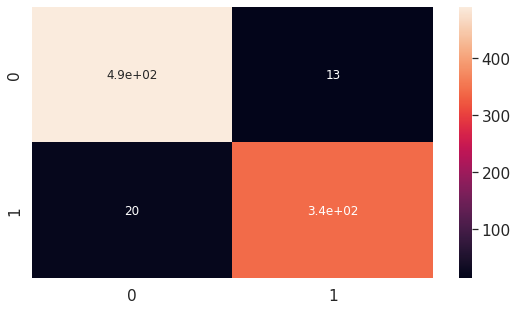

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 224_input (InputLayer)      [(None, 224, 224, 1)]     0         
                                                                 
 224_block1_conv1 (Conv2D)   (None, 224, 224, 64)      640       
                                                                 
 224_block1_conv2 (Conv2D)   (None, 224, 224, 64)      36928     
                                                                 
 224_block1_pool (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 224_block2_conv1 (Conv2D)   (None, 112, 112, 128)     73856     
                                                                 
 224_block2_conv2 (Conv2D)   (None, 112, 112, 128)     147584    
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Accuracy: 0.9272517321016166
F1 score: 0.9267915814956098
Recall: 0.9272517321016166
Precision: 0.9282186943701659

 clasification report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       504
           1       0.95      0.88      0.91       362

    accuracy                           0.93       866
   macro avg       0.93      0.92      0.92       866
weighted avg       0.93      0.93      0.93       866


 confusion matrix:
 [[486  18]
 [ 45 317]]


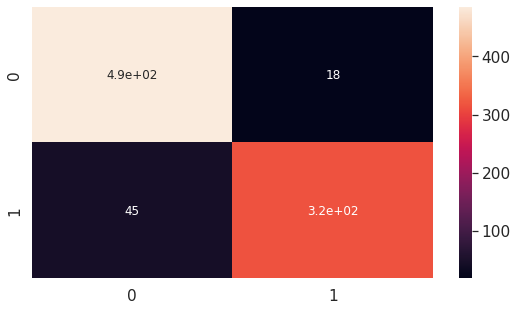

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 224_input (InputLayer)      [(None, 224, 224, 1)]     0         
                                                                 
 224_block1_conv1 (Conv2D)   (None, 224, 224, 64)      640       
                                                                 
 224_block1_conv2 (Conv2D)   (None, 224, 224, 64)      36928     
                                                                 
 224_block1_pool (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 224_block2_conv1 (Conv2D)   (None, 112, 112, 128)     73856     
                                                                 
 224_block2_conv2 (Conv2D)   (None, 112, 112, 128)     147584    
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Accuracy: 0.9191685912240185
F1 score: 0.9180803985023929
Recall: 0.9191685912240185
Precision: 0.923571129737078

 clasification report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93       504
           1       0.97      0.83      0.90       362

    accuracy                           0.92       866
   macro avg       0.93      0.91      0.91       866
weighted avg       0.92      0.92      0.92       866


 confusion matrix:
 [[494  10]
 [ 60 302]]


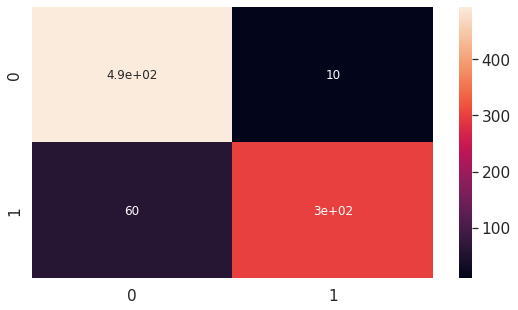

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 224_input (InputLayer)      [(None, 224, 224, 1)]     0         
                                                                 
 224_block1_conv1 (Conv2D)   (None, 224, 224, 64)      640       
                                                                 
 224_block1_conv2 (Conv2D)   (None, 224, 224, 64)      36928     
                                                                 
 224_block1_pool (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 224_block2_conv1 (Conv2D)   (None, 112, 112, 128)     73856     
                                                                 
 224_block2_conv2 (Conv2D)   (None, 112, 112, 128)     147584    
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Accuracy: 0.9145496535796767
F1 score: 0.9149746530000353
Recall: 0.9145496535796767
Precision: 0.9182327426394057

 clasification report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92       504
           1       0.86      0.94      0.90       362

    accuracy                           0.91       866
   macro avg       0.91      0.92      0.91       866
weighted avg       0.92      0.91      0.91       866


 confusion matrix:
 [[450  54]
 [ 20 342]]


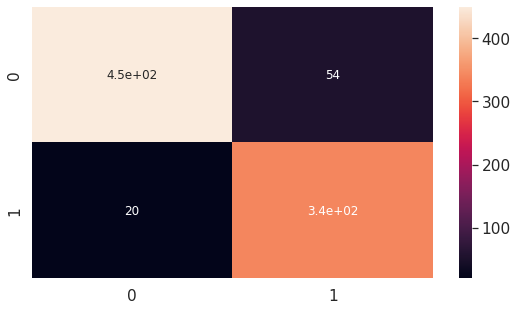

In [ ]:
op = ['normal','both pre','normalize','standarize']
for i in op:
  if i == 'normal':
    X_train = train_npy
    X_test = test_npy
    X = np.concatenate((X_train,X_test))
    Y = np.concatenate((y_train, y_test))
    model = get_model_VGG19_gray()
    model.load_weights('/content/drive/MyDrive/Bias Covid/logs/VGG19_1CH_imagenet_Cohen_'+i+'.h5')
    predictions=model.predict(X)
    y_pred_bool1 = np.argmax(predictions, axis=-1)
    y_hat=np.argmax(Y,axis=-1)
    metrics(y_hat,y_pred_bool1)
    labels = ["No-Covid","Covid"]
    get_performance_metrics(Y,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                            sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)
  if i == 'both pre':
    X_train = train_npy
    X_test = test_npy
    X_train,y_train=min_max_preprocessing(X_train,y_train)
    X_test,y_test=min_max_preprocessing(X_test,y_test)
    X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)
    X_test=featurewise_preprocessing(X_test,mean,std)
    X = np.concatenate((X_train,X_test))
    Y = np.concatenate((y_train, y_test))
    model = get_model_VGG19_gray()
    model.load_weights('/content/drive/MyDrive/Bias Covid/logs/VGG19_1CH_imagenet_Cohen_'+i+'.h5')
    predictions=model.predict(X)
    y_pred_bool2 = np.argmax(predictions, axis=-1)
    y_hat=np.argmax(Y,axis=-1)
    metrics(y_hat,y_pred_bool2)
    labels = ["No-Covid","Covid"]
    get_performance_metrics(Y,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                            sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)
  if i == 'normalize':
    X_train = train_npy
    X_test = test_npy
    X_train,y_train=min_max_preprocessing(X_train,y_train)
    X_test,y_test=min_max_preprocessing(X_test,y_test)
    X = np.concatenate((X_train,X_test))
    Y = np.concatenate((y_train, y_test))
    model = get_model_VGG19_gray()
    model.load_weights('/content/drive/MyDrive/Bias Covid/logs/VGG19_1CH_imagenet_Cohen_'+i+'.h5')
    predictions=model.predict(X)
    y_pred_bool3 = np.argmax(predictions, axis=-1)
    y_hat=np.argmax(Y,axis=-1)
    metrics(y_hat,y_pred_bool3)
    labels = ["No-Covid","Covid"]
    get_performance_metrics(Y,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                            sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)
  if i == 'standarize':
    X_train = train_npy
    X_test = test_npy
    X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)
    X_test=featurewise_preprocessing(X_test,mean,std)
    X = np.concatenate((X_train,X_test))
    Y = np.concatenate((y_train, y_test))
    model = get_model_VGG19_gray()
    model.load_weights('/content/drive/MyDrive/Bias Covid/logs/VGG19_1CH_imagenet_Cohen_'+i+'.h5')
    predictions=model.predict(X)
    y_pred_bool4 = np.argmax(predictions, axis=-1)
    y_hat=np.argmax(Y,axis=-1)
    metrics(y_hat,y_pred_bool4)
    labels = ["No-Covid","Covid"]
    get_performance_metrics(Y,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                            sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)


##Saving the best result on the dataset for the Aequitas tool

In [ ]:
df = data_train.append(data_test, ignore_index=True)
df.head()

,Unnamed: 0,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [ ]:
d = {'score':y_pred_bool1 , 'label_value': y_hat, 'age':df['age'].astype(str), 'sex':df['sex'], 'went_icu':df['went_icu'], 'location':df['location'].str.split().str[-1],'date':df['date'].str.split().str[-1]}
df2 = pd.DataFrame(data=d)
df2.head()

,score,label_value,age,sex,went_icu,location,date
0,0,0,65.0,M,N,Vietnam,2020
1,0,0,65.0,M,N,Vietnam,2020
2,0,0,65.0,M,N,Vietnam,2020
3,0,0,65.0,M,N,Vietnam,2020
4,0,0,52.0,F,N,Taiwan,2020


In [ ]:
df2.to_csv('/content/drive/MyDrive/Bias Covid/df_pred1.csv',index=False)

In [ ]:
df2.to_excel('/content/drive/MyDrive/Bias Covid/df_pred1.xlsx')

## Test Results using only test set

80150528/80134624 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 224_input (InputLayer)      [(None, 224, 224, 1)]     0         
                                                                 
 224_block1_conv1 (Conv2D)   (None, 224, 224, 64)      640       
                                                                 
 224_block1_conv2 (Conv2D)   (None, 224, 224, 64)      36928     
                                                                 
 224_block1_pool (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 224_block2_conv1 (Conv2D)   (None, 112, 112, 128)     73856     
                                                                 
 224_block2_conv2 (Conv2D)   (None, 112, 112, 128)     14758

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Accuracy: 0.7962962962962963
F1 score: 0.7937828790052608
Recall: 0.7962962962962963
Precision: 0.7944182389937107

 clasification report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84        99
           1       0.77      0.68      0.72        63

    accuracy                           0.80       162
   macro avg       0.79      0.78      0.78       162
weighted avg       0.79      0.80      0.79       162


 confusion matrix:
 [[86 13]
 [20 43]]


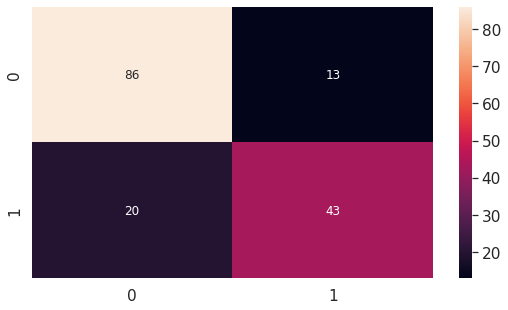

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 224_input (InputLayer)      [(None, 224, 224, 1)]     0         
                                                                 
 224_block1_conv1 (Conv2D)   (None, 224, 224, 64)      640       
                                                                 
 224_block1_conv2 (Conv2D)   (None, 224, 224, 64)      36928     
                                                                 
 224_block1_pool (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 224_block2_conv1 (Conv2D)   (None, 112, 112, 128)     73856     
                                                                 
 224_block2_conv2 (Conv2D)   (None, 112, 112, 128)     147584    
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Accuracy: 0.9272517321016166
F1 score: 0.9267915814956098
Recall: 0.9272517321016166
Precision: 0.9282186943701659

 clasification report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       504
           1       0.95      0.88      0.91       362

    accuracy                           0.93       866
   macro avg       0.93      0.92      0.92       866
weighted avg       0.93      0.93      0.93       866


 confusion matrix:
 [[486  18]
 [ 45 317]]


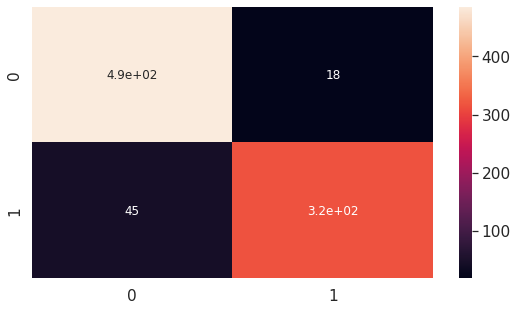

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 224_input (InputLayer)      [(None, 224, 224, 1)]     0         
                                                                 
 224_block1_conv1 (Conv2D)   (None, 224, 224, 64)      640       
                                                                 
 224_block1_conv2 (Conv2D)   (None, 224, 224, 64)      36928     
                                                                 
 224_block1_pool (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 224_block2_conv1 (Conv2D)   (None, 112, 112, 128)     73856     
                                                                 
 224_block2_conv2 (Conv2D)   (None, 112, 112, 128)     147584    
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Accuracy: 0.9191685912240185
F1 score: 0.9180803985023929
Recall: 0.9191685912240185
Precision: 0.923571129737078

 clasification report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93       504
           1       0.97      0.83      0.90       362

    accuracy                           0.92       866
   macro avg       0.93      0.91      0.91       866
weighted avg       0.92      0.92      0.92       866


 confusion matrix:
 [[494  10]
 [ 60 302]]


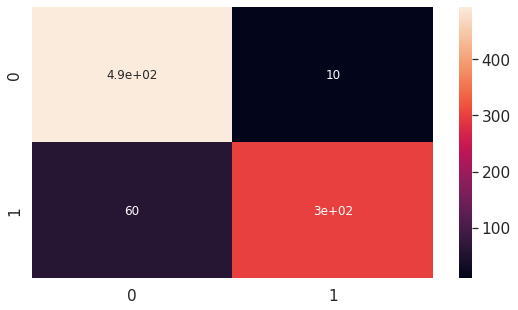

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 224_input (InputLayer)      [(None, 224, 224, 1)]     0         
                                                                 
 224_block1_conv1 (Conv2D)   (None, 224, 224, 64)      640       
                                                                 
 224_block1_conv2 (Conv2D)   (None, 224, 224, 64)      36928     
                                                                 
 224_block1_pool (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 224_block2_conv1 (Conv2D)   (None, 112, 112, 128)     73856     
                                                                 
 224_block2_conv2 (Conv2D)   (None, 112, 112, 128)     147584    
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Accuracy: 0.9145496535796767
F1 score: 0.9149746530000353
Recall: 0.9145496535796767
Precision: 0.9182327426394057

 clasification report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92       504
           1       0.86      0.94      0.90       362

    accuracy                           0.91       866
   macro avg       0.91      0.92      0.91       866
weighted avg       0.92      0.91      0.91       866


 confusion matrix:
 [[450  54]
 [ 20 342]]


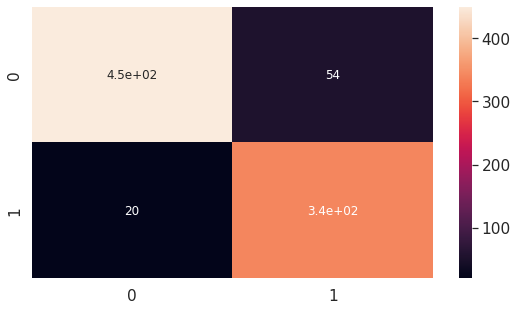

In [ ]:
op = ['normal','both pre','normalize','standarize']
for i in op:
  if i == 'normal':
    X_train = train_npy
    X_test = test_npy
    X = X_test
    Y = y_test
    model = get_model_VGG19_gray()
    model.load_weights('/content/drive/MyDrive/Bias Covid/logs/VGG19_1CH_imagenet_Cohen_'+i+'.h5')
    predictions=model.predict(X)
    y_pred_bool1 = np.argmax(predictions, axis=-1)
    y_hat=np.argmax(Y,axis=-1)
    metrics(y_hat,y_pred_bool1)
    labels = ["No-Covid","Covid"]
    get_performance_metrics(Y,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                            sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)
  if i == 'both pre':
    X_train = train_npy
    X_test = test_npy
    X_train,y_train=min_max_preprocessing(X_train,y_train)
    X_test,y_test=min_max_preprocessing(X_test,y_test)
    X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)
    X_test=featurewise_preprocessing(X_test,mean,std)
    X = np.concatenate((X_train,X_test))
    Y = np.concatenate((y_train, y_test))
    model = get_model_VGG19_gray()
    model.load_weights('/content/drive/MyDrive/Bias Covid/logs/VGG19_1CH_imagenet_Cohen_'+i+'.h5')
    predictions=model.predict(X)
    y_pred_bool2 = np.argmax(predictions, axis=-1)
    y_hat=np.argmax(Y,axis=-1)
    metrics(y_hat,y_pred_bool2)
    labels = ["No-Covid","Covid"]
    get_performance_metrics(Y,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                            sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)
  if i == 'normalize':
    X_train = train_npy
    X_test = test_npy
    X_train,y_train=min_max_preprocessing(X_train,y_train)
    X_test,y_test=min_max_preprocessing(X_test,y_test)
    X = np.concatenate((X_train,X_test))
    Y = np.concatenate((y_train, y_test))
    model = get_model_VGG19_gray()
    model.load_weights('/content/drive/MyDrive/Bias Covid/logs/VGG19_1CH_imagenet_Cohen_'+i+'.h5')
    predictions=model.predict(X)
    y_pred_bool3 = np.argmax(predictions, axis=-1)
    y_hat=np.argmax(Y,axis=-1)
    metrics(y_hat,y_pred_bool3)
    labels = ["No-Covid","Covid"]
    get_performance_metrics(Y,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                            sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)
  if i == 'standarize':
    X_train = train_npy
    X_test = test_npy
    X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)
    X_test=featurewise_preprocessing(X_test,mean,std)
    X = np.concatenate((X_train,X_test))
    Y = np.concatenate((y_train, y_test))
    model = get_model_VGG19_gray()
    model.load_weights('/content/drive/MyDrive/Bias Covid/logs/VGG19_1CH_imagenet_Cohen_'+i+'.h5')
    predictions=model.predict(X)
    y_pred_bool4 = np.argmax(predictions, axis=-1)
    y_hat=np.argmax(Y,axis=-1)
    metrics(y_hat,y_pred_bool4)
    labels = ["No-Covid","Covid"]
    get_performance_metrics(Y,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                            sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)